# Objective
Here, we download a random image from the internet and get the gaze direction of people present in it.

**A primer on Yaw,Pitch angles:**

1. Left looking gaze => +ve Yaw
2. Right looking gaze => -ve Yaw
3. Up looking gaze => +ve Pitch
4. Down looking gaze => -ve Pitch
5. When the person is looking backwards, |Yaw| >90 degree

In [1]:
import sys
import os
sys.path.append(os.path.expanduser("~/code/MultiZoomGaze/code/"))

## Checkpoint file
Download the checkpoint file to your computer and give the path of the file below.
Note that there are multiple checkpoint files given at https://github.com/ashesh-0/MultiZoomGaze which are for different purposes. For this notebook,
you just need one checkpoint file with the name given in the below cell. 

In [2]:
checkpoint_test = os.path.expanduser("~/gaze_final_checkpoints/model_best_multiZoomGaze_TYPE:41_bkb:0_time:False_diff_crop:224-150_seq_len:4_atype:2_bsz:64_lr:0.0001_v:master_1.pth.tar")

## Loading the model

In [3]:
import matplotlib.pyplot as plt

import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

from sinecosine_model.non_lstm_based_model import AggregationType, GazeSinCosMultiCropModel
from core.train_utils import checkpoint_params
from core.transforms import centercrop_transform
from sinecosine_model.train_utils import compute_yaw_pitch


In [4]:
cropsize_list = [224,200,175,150]

params = checkpoint_params(checkpoint_test)
backbone_type = int(params['bkb'])
atype = int(params['atype'])
seq_len = len(cropsize_list)

model_v = GazeSinCosMultiCropModel(
            seq_len=seq_len,
            backbone_type=backbone_type,
            atype=atype,
            cropsize_list=cropsize_list,
        )

model = torch.nn.DataParallel(model_v).cuda()
_= model.cuda()

checkpoint = torch.load(checkpoint_test)
_ = model.load_state_dict(checkpoint['state_dict'])
_ = model.eval()

[Backbone] Using Resnet18 Pretrained:True
[GazeSinCosMultiCropModel] Freeze:0 Bi-direc:True TargetIdx:2
[BackboneCNN] Using Resnet18 Pretrained:True
[BackboneHead] Using Resnet18 Pretrained:True
[AggregationModule] AggregationMode:SPATIAL_MAX


In [5]:
zoomin_transforms = [centercrop_transform(c, 224) for c in cropsize_list]

def get_input(img):
    source_video = torch.FloatTensor(len(cropsize_list), 3, 224, 224)
    for i, transform in enumerate(zoomin_transforms):
        source_video[i, ...] = transform(img.copy())

    source_video = source_video.view(3 * len(cropsize_list), 224, 224)
    return source_video


## Downloading a random image containing people

In [6]:
!wget https://cdn.pixabay.com/photo/2016/03/09/09/22/meeting-1245776_960_720.jpg 

--2021-11-05 00:41:42--  https://cdn.pixabay.com/photo/2016/03/09/09/22/meeting-1245776_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.20.183, 104.18.21.183
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.20.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125830 (123K) [image/jpeg]
Saving to: ‘meeting-1245776_960_720.jpg.5’

meeting-1245776_960 100%[===================>] 122.88K  --.-KB/s    in 0.02s   

2021-11-05 00:41:42 (4.85 MB/s) - ‘meeting-1245776_960_720.jpg.5’ saved [125830/125830]



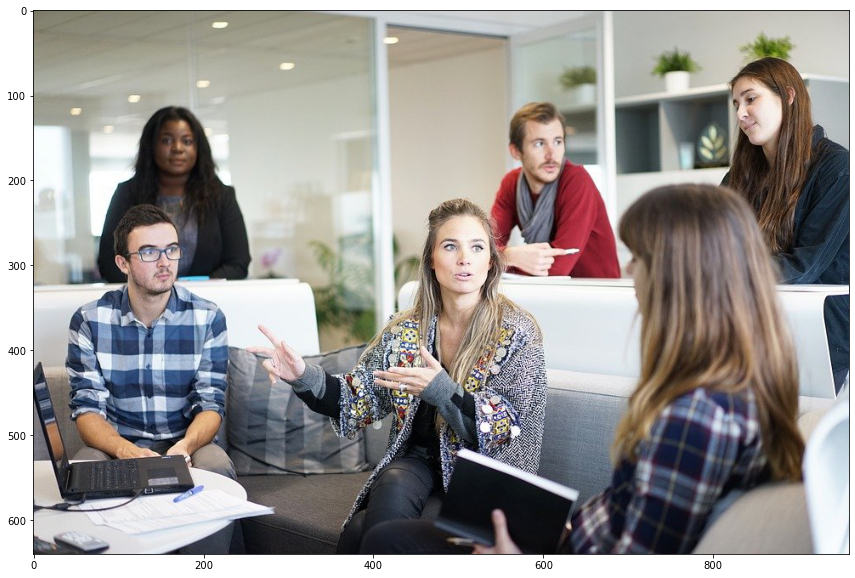

In [55]:
img = np.array(Image.open('meeting-1245776_960_720.jpg'))
_,ax = plt.subplots(figsize=(15,10))
plt.imshow(img)

## Getting a bounding box
Here, I've gotten lazy and have used manually created the bounding boxes. Hopefully, some day, I will integrate a head crop detector in this notebook :) 

In [34]:
bbox_list = [
[220,85,120,100],
[100,540,100,100],
[180,650,220,220],
[210,420,150,150],
[50,800,120,120],
[100,110,120,100]
]
bbox_list = sorted(bbox_list, key=lambda x: x[-1]*x[-2])

In [39]:
import math
def to_degree(rad):
    return f'{round(rad *180/math.pi,0)}\N{DEGREE SIGN}'

def pad_to_same_size(img):
    H,W, _ = img.shape
    return np.pad(new_img, (
        ((224-H)//2,(224-H)//2),
        ((224-W)//2,(224-W)//2),
        (0,0))
                 )

## Showing the gaze on these head crops
For images of all sizes, our model is able to predict qualitatively correct direction. For example, in the first two images, the first head crop is looking more rightwards and our model also predicts more negative yaw angle for it. 

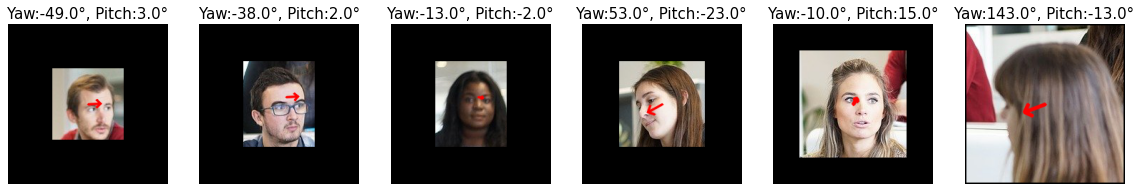

In [43]:
from plot_utils import draw_gaze
ncols  = len(bbox_list)
img_sz = 20/ncols
_,ax = plt.subplots(figsize=(20,img_sz),ncols=ncols)
for i, bbox in enumerate(bbox_list):
    head_crop = img[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
    batch = get_input(Image.fromarray(head_crop))[None]
    with torch.no_grad():
        gaze, uncertain = model(batch)
        yawpitch = compute_yaw_pitch(gaze)
        

    new_img = draw_gaze(
        head_crop, 
        (head_crop.shape[0]//2,head_crop.shape[1]//2),
        yawpitch.numpy()[0][::-1], 
        length=50/224 * head_crop.shape[0], 
        thickness=int(np.ceil(3/224* head_crop.shape[0])),
        tiplength=0.4,
        color=(255,0,0),
    )



    _ = ax[i].imshow(pad_to_same_size(new_img))
    msg = f'Yaw:{to_degree(yawpitch[0,0].item())}, Pitch:{to_degree(yawpitch[0,1].item())}'
    ax[i].set_title(msg, fontsize=15)
    ax[i].tick_params(left=False, right=False, top=False, bottom=False)
    ax[i].axis('off')


## How Prediction fluctuates with Scale Variation
We find that our model is relatively robust to scale variation. Here, instead of the default head crop, a slightly zoomed-in or zoomed-out head crop is used as input. And we see how the Yaw and Pitch values fluctuates. 

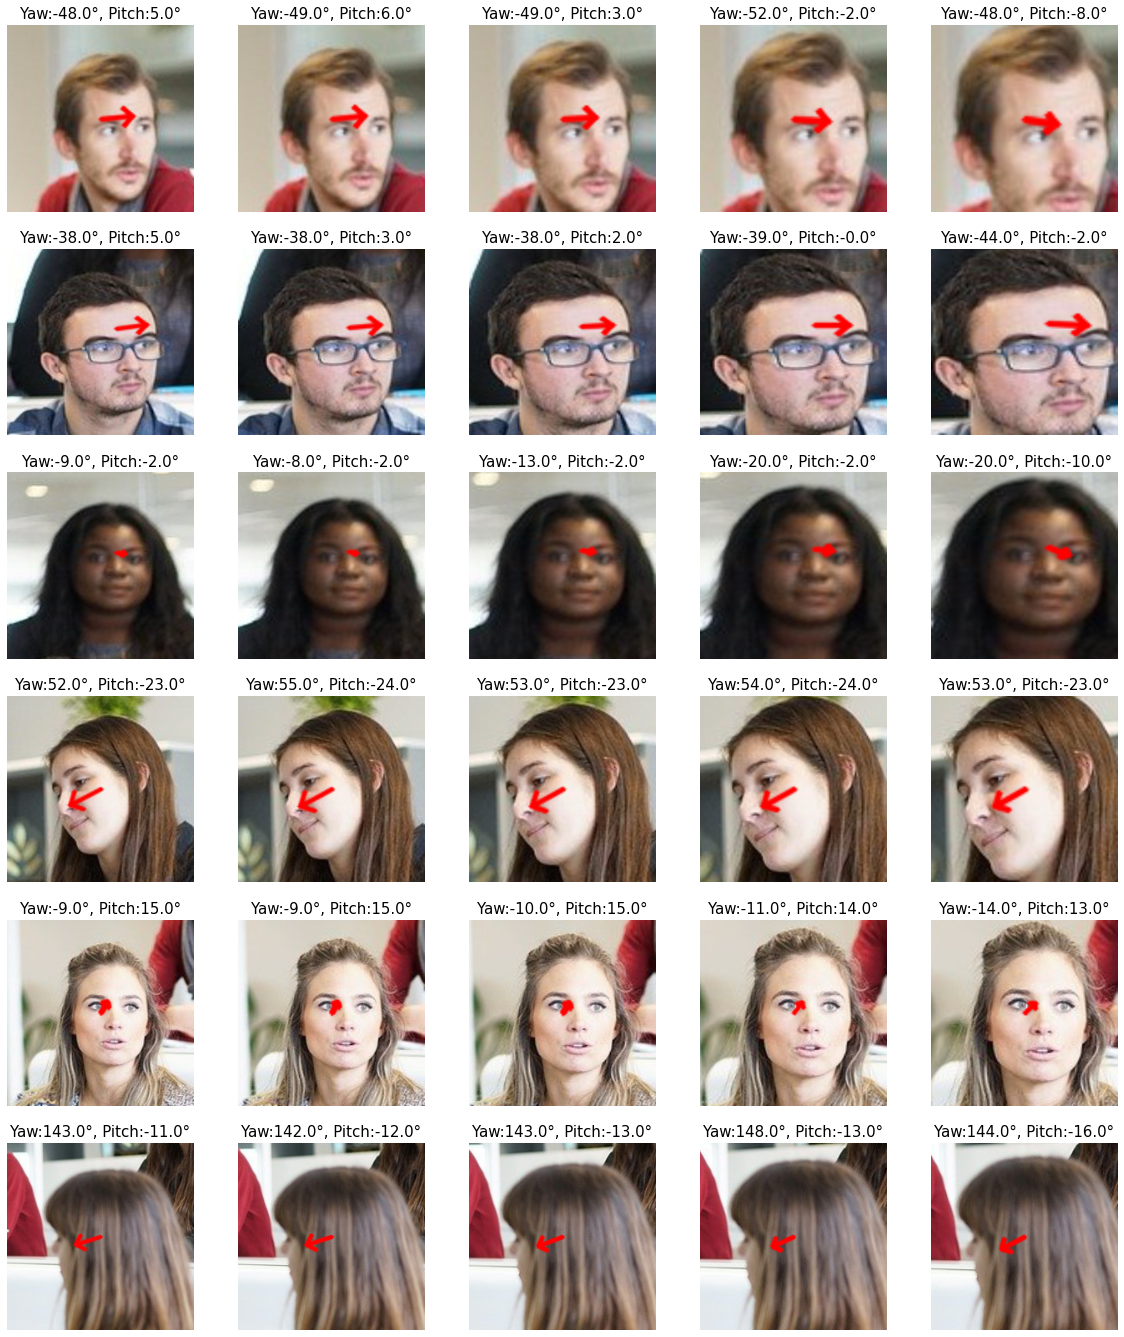

In [54]:
scale_variation_list = [-10,-5,0,5,10]
ncols  = len(scale_variation_list)
nrows = len(bbox_list)
img_sz = 20/ncols

_,ax = plt.subplots(figsize=(20,img_sz*nrows),ncols=ncols, nrows=nrows)
for row_idx, bbox in enumerate(bbox_list):
    for i,scale_variation in enumerate(scale_variation_list):
        head_crop = img[bbox[0]+scale_variation:bbox[0]+bbox[2]-scale_variation,
                        bbox[1]+scale_variation:bbox[1]+bbox[3]-scale_variation]
        batch = get_input(Image.fromarray(head_crop))[None]
        with torch.no_grad():
            gaze, uncertain = model(batch)
            yawpitch = compute_yaw_pitch(gaze)


        new_img = draw_gaze(
            head_crop, 
            (head_crop.shape[0]//2,head_crop.shape[1]//2),
            yawpitch.numpy()[0][::-1], 
            length=50/224 * head_crop.shape[0], 
            thickness=int(np.ceil(3/224* head_crop.shape[0])),
            tiplength=0.4,
            color=(255,0,0),
        )



        _ = ax[row_idx,i].imshow(transforms.Resize((224, 224))(Image.fromarray(new_img)))
        msg = f'Yaw:{to_degree(yawpitch[0,0].item())}, Pitch:{to_degree(yawpitch[0,1].item())}'
        ax[row_idx,i].set_title(msg, fontsize=15)
        ax[row_idx,i].tick_params(left=False, right=False, top=False, bottom=False)
        ax[row_idx, i].axis('off')
